Basic imports:


In [ ]:
import torch
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import EMNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

Transformation for the dataset:

In [ ]:
# Transformation for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


Load EMNIST dataset :

In [ ]:
# Load EMNIST dataset
train_dataset = EMNIST(root='./data', split='letters', train=True, transform=transform, download=True)
test_dataset = EMNIST(root='./data', split='letters', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 561753746/561753746 [00:08<00:00, 65493720.01it/s]


Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw


Visual function :

In [ ]:
# Visual function
def show(tensor, ch=1, size=(28, 28), num=16):
    data = tensor.detach().cpu().view(-1, ch, *size)
    grid = make_grid(data[:num], nrow=4, normalize=True).permute(1, 2, 0)
    plt.imshow(grid)
    plt.show()

Hyperparameters :

In [ ]:
# Hyperparameters
epochs = 100
cur_step = 0
info_step = 300
z_dim = 64
lr = 0.0002
bs = 256
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [ ]:
# Load EMNIST data
dataloader = DataLoader(EMNIST('.', split='letters', download=True, transform=transform), shuffle=True, batch_size=bs,)

100%|██████████| 561753746/561753746 [00:03<00:00, 159997385.89it/s]


Extracting ./EMNIST/raw/gzip.zip to ./EMNIST/raw


In [ ]:
# Weight initialization
def weights_init(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [ ]:
# Generator class
class Generator(nn.Module):
    def __init__(self, z_dim=64, i_dim=784, h_dim=128):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, h_dim * 8),
            nn.ReLU(True),
            nn.Linear(h_dim * 8, h_dim * 4),
            nn.ReLU(True),
            nn.Linear(h_dim * 4, h_dim * 2),
            nn.ReLU(True),
            nn.Linear(h_dim * 2, h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim, i_dim),
            nn.Tanh()  # Tanh activation for the final layer
        )
        self.apply(weights_init)  # Apply weight initialization

    def forward(self, noise):
        return torch.tanh(self.gen(noise))  # Apply tanh activation

In [ ]:
# Noise generation function
def gen_noise(number, z_dim):
    return torch.randn(number, z_dim).to(device)

In [ ]:
# Discriminator class
class Discriminator(nn.Module):
    def __init__(self, i_dim=784, h_dim=256):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Linear(i_dim, h_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(h_dim, h_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(h_dim * 2, h_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(h_dim * 4, 1),
            nn.Sigmoid()  # Sigmoid activation for binary classification
        )
        self.apply(weights_init)  # Apply weight initialization

    def forward(self, image):
        return self.disc(image)

In [ ]:
# Initialize models and optimizers
gen = Generator(z_dim).to(device)
gen_optim = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
disc = Discriminator().to(device)
disc_optim = torch.optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
# Loss function
loss_func = nn.BCELoss()

In [ ]:
# Loss Functions for Generator and Discriminator
def calc_gen_loss(gen, disc, loss_func, number, z_dim):
    noise = gen_noise(number, z_dim)
    fake = gen(noise)
    pred = disc(fake)
    targets = torch.ones_like(pred)
    gen_loss = loss_func(pred, targets)
    return gen_loss

def calc_disc_loss(gen, disc, loss_func, number, real, z_dim):
    noise = gen_noise(number, z_dim)
    fake = gen(noise)
    disc_fake = disc(fake.detach())
    disc_fake_targets = torch.zeros_like(disc_fake)
    disc_fake_loss = loss_func(disc_fake, disc_fake_targets)
    disc_real = disc(real)
    disc_real_targets = torch.ones_like(disc_real)
    disc_real_loss = loss_func(disc_real, disc_real_targets)
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    return disc_loss


  0%|          | 0/488 [00:00<?, ?it/s]

Epoch 0, Step 300, Mean Gen Loss: 1.8271492769631243, Mean Disc Loss: 0.37773828429480394


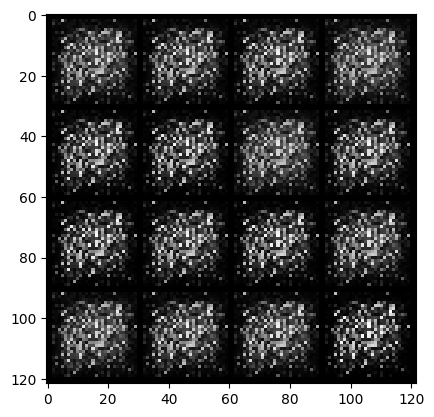

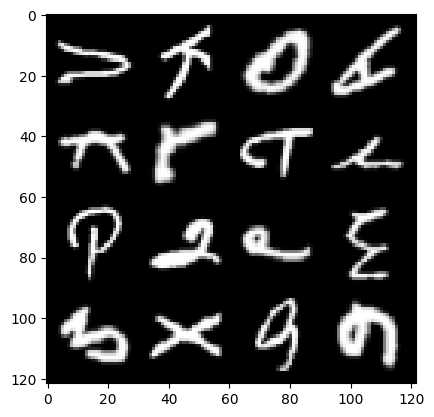

  0%|          | 0/488 [00:00<?, ?it/s]

Epoch 1, Step 600, Mean Gen Loss: 2.2154510732491803, Mean Disc Loss: 0.06488042595912705


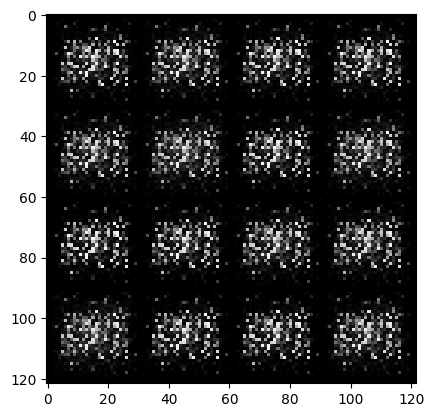

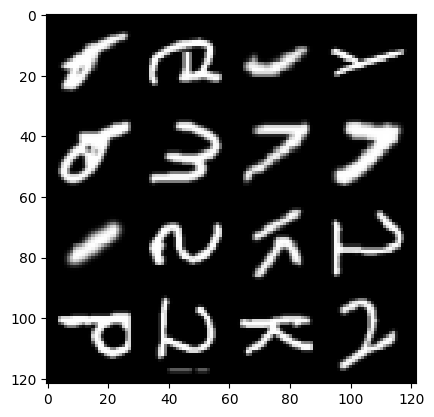

Epoch 1, Step 900, Mean Gen Loss: 5.788132348557313, Mean Disc Loss: 0.09005871212032324


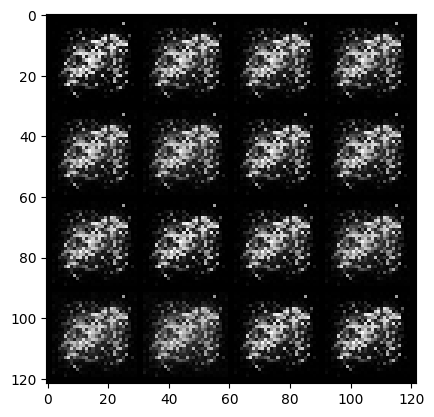

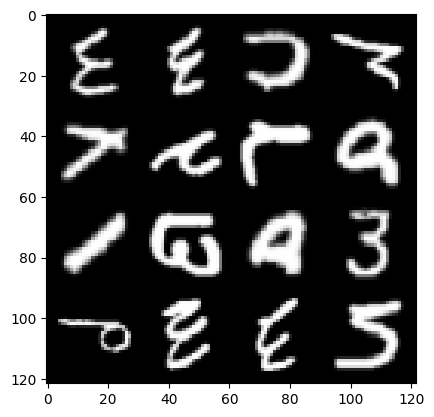

  0%|          | 0/488 [00:00<?, ?it/s]

Epoch 2, Step 1200, Mean Gen Loss: 4.909190845092134, Mean Disc Loss: 0.05090998576255513


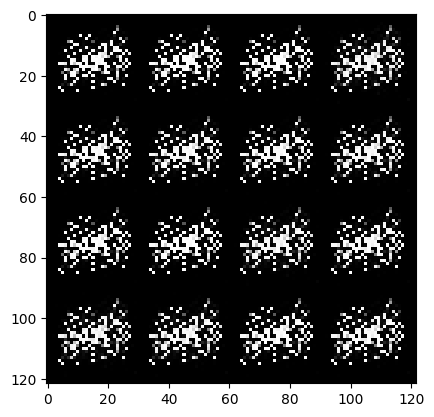

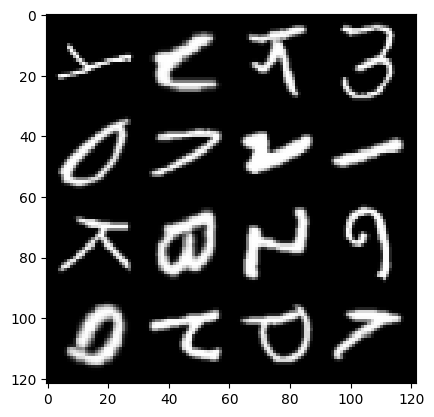

  0%|          | 0/488 [00:00<?, ?it/s]

Epoch 3, Step 1500, Mean Gen Loss: 1.055148164232572, Mean Disc Loss: 0.03106680118323615


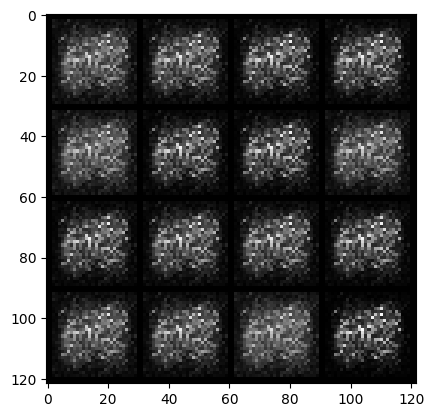

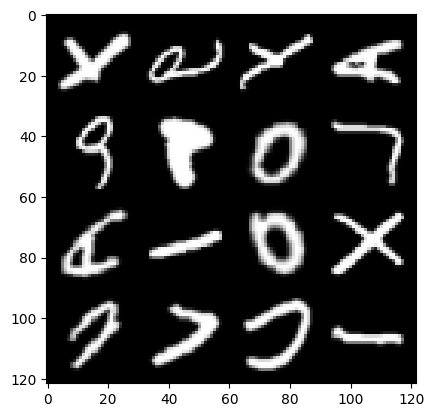

Epoch 3, Step 1800, Mean Gen Loss: 6.746178719600045, Mean Disc Loss: 0.047994858598103735


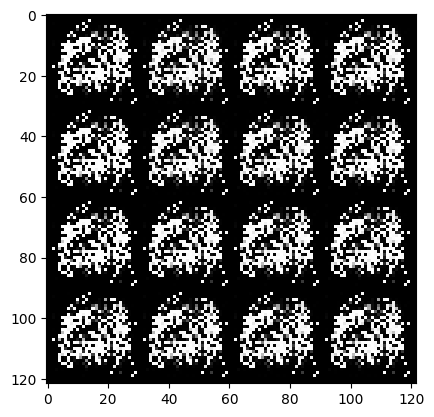

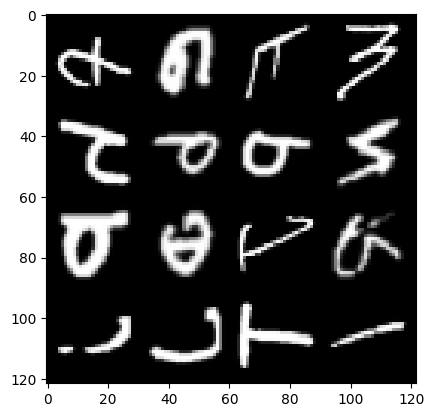

  0%|          | 0/488 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Training loop
for epoch in range(epochs):
    mean_gen_loss = 0  # Initialize mean_gen_loss for the epoch
    mean_disc_loss = 0  # Initialize mean_disc_loss for the epoch

    for real, _ in tqdm(dataloader):
        # Train discriminator
        disc_optim.zero_grad()
        cur_bs = len(real)
        real = real.view(cur_bs, -1).to(device)
        disc_loss = calc_disc_loss(gen, disc, loss_func, cur_bs, real, z_dim)
        disc_loss.backward()
        disc_optim.step()

        # Train generator
        gen_optim.zero_grad()
        gen_loss = calc_gen_loss(gen, disc, loss_func, cur_bs, z_dim)
        gen_loss.backward()
        gen_optim.step()

        # Accumulate losses
        mean_disc_loss += disc_loss.item() / info_step
        mean_gen_loss += gen_loss.item() / info_step

        if cur_step % info_step == 0 and cur_step > 0:
            print(f"Epoch {epoch}, Step {cur_step}, Mean Gen Loss: {mean_gen_loss}, Mean Disc Loss: {mean_disc_loss}")
            show(gen(gen_noise(16, z_dim)).view(-1, 1, 28, 28))  # Show generated images
            show(real[:16].view(-1, 1, 28, 28))  # Show real images
            mean_gen_loss = 0
            mean_disc_loss = 0

        cur_step += 1